In [25]:
import cv2
import glob
import numpy as np

In [51]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.models import Model
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [44]:
img_paths = glob.glob('./train2017/00000000[012345][0123456789][0123456789][0123456789].jpg')

In [45]:
len(img_paths)

1168

In [50]:
for img_path in img_paths:
    img = cv2.imread(img_path)
    x,y,_ = img.shape
    margin = (y-x)//2
    #print(img_path.split('/')[-1])
    img = img[:,margin:y-margin]
    img = cv2.resize(img, (128,128))
    cv2.imwrite('./cleaned-data/' + img_path.split('/')[-1], img)

In [85]:
def build_encoder(input_shape, name='encoder'):
    input_layer = Input(shape=input_shape)
    
    # first encoding block
    encode1 = Conv2D(8, 3, padding='same', activation='relu')(input_layer)
    encode1 = Conv2D(8, 3, padding='same', activation='relu')(encode1)
    encode1 = MaxPool2D()(encode1)
    
    # Second encoding block
    encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode1)
    encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode2)
    encode2 = MaxPool2D()(encode2)
    
    # Third encoding block
    encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode2)
    encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode3)
    encode3 = MaxPool2D()(encode3)
    
    output_layer = encode3
    return Model(input_layer, output_layer, name=name)

In [86]:
encoder = build_encoder((128,128,3))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
__________

In [87]:
def build_decoder(input_shape, name='decoder'):
    input_layer = Input(shape=input_shape)
    
    # first decoding block
    decode1 = UpSampling2D()(input_layer)
    decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
    decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
    
    
    # Second decoding block
    decode2 = UpSampling2D()(decode1)
    decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
    decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
    
    
    # Third decoding block
    decode3 = UpSampling2D()(decode2)
    decode3 = Conv2D(4, 3, padding='same', activation='relu')(decode3)
    decode3 = Conv2D(3, 3, padding='same', activation='relu')(decode3)
    
    
    output_layer = decode3
    return Model(input_layer, output_layer, name=name)

In [88]:
decoder = build_decoder((16,16,32))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 8)         1160      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 64, 64, 8)         584       
__________

In [94]:
def build_autoencoder():
    input_img = Input(shape=(128,128,3))
    latent_representation = encoder(input_img)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_img, decoded_img, name="autoencoder")
    return autoencoder

In [95]:
autoencoder = build_autoencoder()

In [96]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              (None, 16, 16, 32)        18184     
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       9091      
Total params: 27,275
Trainable params: 27,275
Non-trainable params: 0
_________________________________________________________________


In [140]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [103]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [104]:
X = data_loader('./cleaned-data/')

In [133]:
np.shape(X)
subset_X = X[:100]

In [ ]:
history = autoencoder.fit(subset_X,subset_X, epochs=100, batch_size=25, shuffle=True)

Epoch 1/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0073 - acc: 0.7728
Epoch 2/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0073 - acc: 0.7710
Epoch 3/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0072 - acc: 0.7806
Epoch 4/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0072 - acc: 0.7734
Epoch 5/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0072 - acc: 0.7852
Epoch 6/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0071 - acc: 0.7881
Epoch 7/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0071 - acc: 0.7903
Epoch 8/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0072 - acc: 0.7983
Epoch 9/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0072 - acc: 0.8001
Epoch 10/100
100/100 [==============================] - 2s 24ms/step - loss: 0.0071 - acc: 0.7977
Epoch 11/100
100/100 [=======

100/100 [==============================] - 3s 25ms/step - loss: 0.0083 - acc: 0.7287
Epoch 85/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0081 - acc: 0.7345
Epoch 86/100
100/100 [==============================] - 3s 26ms/step - loss: 0.0077 - acc: 0.7510
Epoch 87/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0074 - acc: 0.7850
Epoch 88/100
100/100 [==============================] - 3s 28ms/step - loss: 0.0075 - acc: 0.7843
Epoch 89/100
100/100 [==============================] - 2s 25ms/step - loss: 0.0075 - acc: 0.7968
Epoch 90/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0073 - acc: 0.7988
Epoch 91/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0075 - acc: 0.7966
Epoch 92/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0073 - acc: 0.7887
Epoch 93/100
100/100 [==============================] - 3s 25ms/step - loss: 0.0074 - acc: 0.8049
Epoch 94/100
100/100 [===========

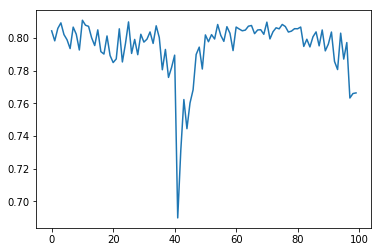

In [184]:
plt.plot(history.history['acc'])

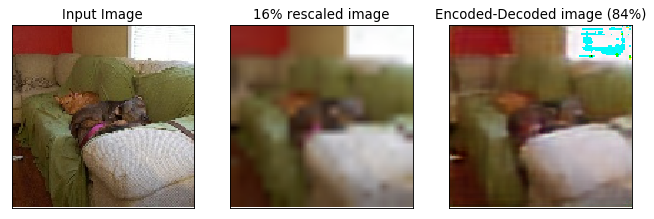

In [181]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    plt.imshow(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.show()

img_index = 69
img_input = subset_X[img_index]
plt.subplot(1,3,1)
plt.title("Input Image")
rgb_imshow(img_input)
plt.xticks([])
plt.yticks([])
scaled_img = cv2.resize((img_input*255).astype(np.uint8), (22,22))
scaled_img = cv2.resize(scaled_img, (128,128))
plt.subplot(1,3,2)
plt.title("16% rescaled image")
plt.imshow(cv2.cvtColor(scaled_img, cv2.COLOR_BGR2RGB))
#plt.show()
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.title("Encoded-Decoded image (84%)")
decoded_img = autoencoder.predict(np.array([img_input]))[0]

rgb_imshow(decoded_img)


plt.xticks([])
plt.yticks([])
plt.show()



In [122]:
decoded_img

array([[[[0.13509443, 0.13617668, 0.20929775],
         [0.16430683, 0.1341766 , 0.19674475],
         [0.19404629, 0.1435808 , 0.20933384],
         ...,
         [0.31039345, 0.24498433, 0.2663633 ],
         [0.28300822, 0.15223086, 0.3472812 ],
         [0.23108506, 0.25252235, 0.27015147]],

        [[0.20823216, 0.18813458, 0.23994002],
         [0.234236  , 0.18196592, 0.24736828],
         [0.24923876, 0.21328235, 0.24935043],
         ...,
         [0.5098297 , 0.38177046, 0.3993932 ],
         [0.38857007, 0.3759736 , 0.49345633],
         [0.21130645, 0.24634132, 0.38560477]],

        [[0.24060237, 0.22312415, 0.2652587 ],
         [0.22180775, 0.1827822 , 0.2622696 ],
         [0.22587103, 0.21989638, 0.2978791 ],
         ...,
         [0.35357445, 0.394129  , 0.389828  ],
         [0.28256956, 0.39301118, 0.43321607],
         [0.3102705 , 0.3222784 , 0.36628094]],

        ...,

        [[0.09880193, 0.10441083, 0.17194518],
         [0.11268328, 0.116405  , 0.09489816]